# Monte Carlo Simulation

This notebok discusses various implementations of the Monte Carlo simluation.

## European Options-GBM
Let us start by pricing European Call and Put options in the Black-Scholes setup (GBM).

In [1]:
set.seed(23)
MonteCarlo <- function(m, n, call){
  dt = Time/n
  nudt = (r - q - 0.5*sig^2) * dt
  sigsdt = sig*sqrt(dt)
  lnS = log(S)
  Sum_CT = 0
  Sum_CT2 = 0
  ptm <- proc.time()
  
  for(j in 1:m) {
    lnSt = lnS
    for(i in 1:n) {
      lnSt = lnSt + nudt + sigsdt*rnorm(1)
    }
    ST = exp(lnSt)
    if (call == TRUE){
      CT = pmax(0,ST - K) }
    else{
      CT = pmax(0,K - ST)}
    Sum_CT = Sum_CT + CT
    Sum_CT2 = Sum_CT2 + CT*CT
    
  }
  price = Sum_CT/m*exp(-r*Time)
  SD = sqrt((Sum_CT2 - Sum_CT*Sum_CT/m)*exp(-2*r*Time)/(m - 1))
  SE = SD/sqrt(m)
  chrono <-(proc.time() - ptm)[3]
  newlist <- list("price" = price, "SE" = SE,"time" = chrono)
  return(newlist)
}

As an example, consider the initial parameters as $r=6\%$, $\delta=0.03$, $\sigma=20\%$, $S_0=100$, $K=100$, and time to maturity $T=1$. We will use 300 time steps and 1 million simulations.

In [2]:
S=100
K=100
Time=1
sig=0.2
r=0.06
q=0.03
#print(MonteCarlo(1000000,300,TRUE))
#print(MonteCarlo(1000000,300,FALSE))

In addition to the price, the function above also gives us the standard error of the estimates and the time it took the system to perform the simulation routine.

### Other Monte Carlo Schemes
We can implement other Monte Carlo Schemes and compare their performance. in this section, we implement these three methods:MC with Antithetic Variates, MC with Delta-based Control Variate, and MC with both Antithetic Variates and Delta-based Control Variate.

#### MC with Antithetic Variates

In [3]:
MCAV <- function(m, n, call){
  dt=Time/n
  nudt=(r-q-0.5*sig^2)*dt
  sigsdt=sig*sqrt(dt)
  lnS=log(S)
  Sum_CT=0
  Sum_CT2=0
  ptm <- proc.time()
  
  
  for(j in 1:m) {
    lnSt1=lnS
    lnSt2=lnS
    for(i in 1:n) {
      lnSt1=lnSt1+nudt+sigsdt*rnorm(1)
      lnSt2=lnSt2+nudt-sigsdt*rnorm(1)
    }
    ST1=exp(lnSt1)
    ST2=exp(lnSt2)
    if (call==TRUE){
      CT=0.5*(pmax(0,ST1-K)+pmax(0,ST2-K)) }
    else{
      CT=0.5*(pmax(0,K-ST1)+pmax(0,K-ST2))}
    Sum_CT=Sum_CT+CT
    Sum_CT2=Sum_CT2+CT*CT
    
  }
  price=Sum_CT/m*exp(-r*Time)
  SD=sqrt((Sum_CT2-Sum_CT*Sum_CT/m)*exp(-2*r*Time)/(m-1))
  SE=SD/sqrt(m)
  chrono <-(proc.time() - ptm)[3]
  newlist <- list("price"=price, "SE"=SE,"time"=chrono)
  return(newlist)
}
#print("MCAV")
#print(MCAV(1000000,300,TRUE))
#print(MCAV(1000000,300,FALSE))


#### MC with Delta-based Control Variate

In [4]:
bscall.delta <- function(S, K, tau, r, q, sigma) {
  d1 <- (log(S/K) + (r + 0.5*sigma^2)*tau)/(sigma*sqrt(tau))
  delta <- exp(-q*tau)*pnorm(d1)
  return(delta)
  }
bsput.delta <- function(S, K, tau, r, q, sigma) {
  d1 <- (log(S/K) + (r + 0.5*sigma^2)*tau)/(sigma*sqrt(tau))
  delta <- exp(-q*tau)*(pnorm(d1)-1)
  return(delta)
}

MCDCV <- function(m,n,call){
  dt=Time/n
  nudt=(r-q-0.5*sig^2)*dt
  sigsdt=sig*sqrt(dt)
  erddt=exp((r-q)*dt)
  beta1=-1

  Sum_CT=0
  Sum_CT2=0
  ptm <- proc.time()
  
  for(j in 1:m) {
    St=S
    cv=0
    for(i in 1:n) {
      t=(i-1)*dt
      if (call==TRUE) {
        delta=bscall.delta(St,K,Time,r,q,sig)
      }
      else {delta=bsput.delta(St,K,Time,r,q,sig)}
      Stn=St*exp(nudt+sigsdt*rnorm(1))
      cv=cv+delta*(Stn-St*erddt)
      St=Stn
    }
    if (call==TRUE){
      CT=pmax(0,St-K)+beta1*cv }
    else{
      CT=pmax(0,K-St)+beta1*cv}
    Sum_CT=Sum_CT+CT
    Sum_CT2=Sum_CT2+CT*CT
    
  }
  price=Sum_CT/m*exp(-r*Time)
  SD=sqrt((Sum_CT2-Sum_CT*Sum_CT/m)*exp(-2*r*Time)/(m-1))
  SE=SD/sqrt(m)
  chrono <-(proc.time() - ptm)[3]
  newlist <- list("price"=price, "SE"=SE,"time"=chrono)
  return(newlist)
}
#print("MCDCV")
#print(MCDCV(100000,300,TRUE))
#print(MCDCV(100000,300,FALSE))

#### MC with both Antithetic Variates and Delta-based Control Variate

In [5]:
MCCombo <- function(m,n,call){
  dt=Time/n
  nudt=(r-q-0.5*sig^2)*dt
  sigsdt=sig*sqrt(dt)
  erddt=exp((r-q)*dt)
  beta1=-1
  
  Sum_CT=0
  Sum_CT2=0
  ptm <- proc.time()
  
  for(j in 1:m) {
    St1=S
    St2=S
    cv1=0
    cv2=0
    for(i in 1:n) {
      t=(i-1)*dt
      if (call==TRUE) {
        delta1=bscall.delta(St1,K,Time,r,q,sig)
        delta2=bscall.delta(St2,K,Time,r,q,sig)
      }
      else {
        delta1=bsput.delta(St1,K,Time,r,q,sig)
        delta2=bsput.delta(St2,K,Time,r,q,sig)
        }
      Stn1=St1*exp(nudt+sigsdt*rnorm(1))
      Stn2=St2*exp(nudt-sigsdt*rnorm(1))
      cv1=cv1+delta1*(Stn1-St1*erddt)
      cv2=cv2+delta2*(Stn2-St2*erddt)
      St1=Stn1
      St2=Stn2
    }
    if (call==TRUE){
      CT=0.5*(pmax(0,St1-K)+beta1*cv1+pmax(0,St2-K)+beta1*cv2) }
    else{
      CT=0.5*(pmax(0,K-St1)+beta1*cv1+pmax(0,K-St2)+beta1*cv2)}
    Sum_CT=Sum_CT+CT
    Sum_CT2=Sum_CT2+CT*CT
    
  }
  price=Sum_CT/m*exp(-r*Time)
  SD=sqrt((Sum_CT2-Sum_CT*Sum_CT/m)*exp(-2*r*Time)/(m-1))
  SE=SD/sqrt(m)
  chrono <-(proc.time() - ptm)[3]
  newlist <- list("price"=price, "SE"=SE,"time"=chrono)
  return(newlist)
}
# print(MCCombo(1000000,300,TRUE))
# print(MCCombo(1000000,300,FALSE))

#### Comaring The Methods
Table below allows for the comparison of the methods.

![table1](img/table1.png)

Choosing the best method in this exercise is not an straight task and requires facing certain trade-offs. Judging based on the Standard Errors, it is clearly obvious that Monte Carlo with both Antithetic Variates, and Delta-based Control Variate provides the best estimates. However, **this improvement is achieved at the cost of an enormous increase in the computation time**. Whether this increase in time is a fair price for smaller standard errors is at best under serious questions. On the other hand, **a major advantage of MCDCV and MCCombo methods is that they can achieve estimates close to that of MC with far less paths**. For example, in this question, pricing the Call option with only 10,000 paths using the MCDCV method leads to 9.13478 and SE=0.022659 in only 30 seconds. Compared to the numbers obtained by the MC, these results cannot be considered weak. This may lead one to believe that these two methods are better than the first two. **But the great drawback of these two methods is that they rely on delta which is calculated by the BSM closed-form formula.** Given that the closed form formula gives Call price=9.1352 and Put price=6.2671, it is not obvious why one should go under the trouble of these computing methods. At last, in choosing between MC and MCAV, benefits of neither outweighs its disadvantages and judgement should be made in a case-by-case basis.

## Heston Model
Consider the Heston stochastic volatility model with parameters:
$S_0 = 100, V_0 = 0.010201, \kappa = 6.21, \theta = 0.019, \sigma = 0.61, \rho= -0.7, r = 3.19\%$. We will apply all the five Euler discretization schemes presented in:

Lord, Roger, Remmert Koekkoek, and Dick Van Dijk. \textit{A comparison of biased simulation schemes for stochastic volatility models.} Quantitative Finance 10.2 (2010): 177-194.

and use Monte Carlo simulations to price a call option with strike $K = 100$ and maturity $T = 1$. The exact call option price (benchmark) is in this case $C_0 = 6.8061$. 

In [7]:
Heston <- function(m,n,call,scheme){
  dt=tau/n
  sigsdt=sig*sqrt(dt)
#  lnS=log(S)
  Sum_CT=0
  Sum_CT2=0
  ptm <- proc.time()
  
  
  for(j in 1:m) {
    Yt=V0
    St=S
    for(i in 1:n) {
      St=St+r*St*dt+St*sqrt(Yt)*rnorm(1)*sqrt(dt)
      
      if(scheme=='absorption'){
        Yt=pmax(Yt,0)+kappa*(theta-pmax(Yt,0))*dt+
          sqrt(pmax(Yt,0))*sigsdt*(rho*rnorm(1)+(sqrt(1-rho^2))*rnorm(1)) 
      }
      
      else if(scheme=='reflection'){
        Yt=abs(Yt)+kappa*(theta-abs(Yt))*dt+
          sqrt(abs(Yt))*sigsdt*(rho*rnorm(1)+(sqrt(1-rho^2))*rnorm(1))  
      }
      
      else if(scheme=='higham'){
        Yt=Yt+kappa*(theta-Yt)*dt+
          sqrt(abs(Yt))*sigsdt*(rho*rnorm(1)+(sqrt(1-rho^2))*rnorm(1))
      }
      
      else if (scheme=='partial'){
        Yt=Yt+kappa*(theta-Yt)*dt+
          sqrt(pmax(Yt,0))*sigsdt*(rho*rnorm(1)+(sqrt(1-rho^2))*rnorm(1))
      }
    
      else if (scheme=='full'){
        Yt=Yt+kappa*(theta-pmax(Yt,0))*dt+
          sqrt(pmax(Yt,0))*sigsdt*(rho*rnorm(1)+(sqrt(1-rho^2))*rnorm(1))
      }
      else return('Only five schemes available')
    }
#    ST=exp(lnSt)
    ST=St
    if (call==TRUE){
      CT=pmax(0,ST-K) }
    else{
      CT=pmax(0,K-ST)}
    Sum_CT=Sum_CT+CT
    Sum_CT2=Sum_CT2+CT*CT
    
  }
  #price=Sum_CT/m*exp(-r*Time)
  price=Sum_CT/m
  #bias=6.8061-price
  bias=0.275695-price
  
  SD=sqrt((Sum_CT2-Sum_CT*Sum_CT/m)*exp(-2*r*Time)/(m-1))
  RMSE=sqrt(SD^2+bias^2)
  chrono <-(proc.time() - ptm)[3]
  newlist <- list("scheme"=scheme, "price"=price,
                  "bias"=bias, "SD"=SD, "RMSE"=RMSE,"time"=chrono)
  return(newlist)
}

# 
# print(Heston(300000,150,TRUE,'absorption'))
# print(Heston(300000,150,TRUE,'reflection'))
# print(Heston(300000,150,TRUE,'higham'))
# print(Heston(300000,150,TRUE,'partial'))
# print(Heston(300000,150,TRUE,'full'))

Results are provided  in Table 2 for comparison:
![table2](img/table2.png)

## Generating Correlated Brownian Motion

Dealing with correlated Brownian motions requires performing a Cholesky decomposition of the correlation matrix, which is a decomposition of the form $\rho=LL^T$, where $\rho$ is the correlation matrix. Consider the following example
$$
A=
\begin{bmatrix}
 1.0 & 0.5 & 0.2\\
 0.5 & 1.0 & -0.4 \\
 0.2 & -0.4 & 1.0
\end{bmatrix}
$$

In [8]:
A=matrix(c(1,0.5,0.2,0.5,1,-0.4,0.2,-0.4,1), nrow = 3, ncol = 3)
LT=chol(A)
L=t(LT)

With three assets, starting with $S(0) = [100, 101, 98]$. The assets are assumed to follow a standard geometric Brownian motion of the form
$$
dS_i(t)=\mu_i S_i (t)dt + \sigma_i S_i(t) dW_i(t) 
$$
Assume $\mu = [0.03, 0.06, 0.02]$, the volatility $\sigma = [0.05, 0.2, 0.15]$, and the
BM's have the correlation matrix $\rho$. Take maturity $T = 100$ days and the number of simulated paths is $m = 1000$. Consider one day sampling frequency, i.e., $\delta t = 1/365$. 
We will generate a 3-dimensional matrix where each row represents a time step, each column represent a separate simulation for a specific asset and the 3rd dimension represents different assets in the basket.

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


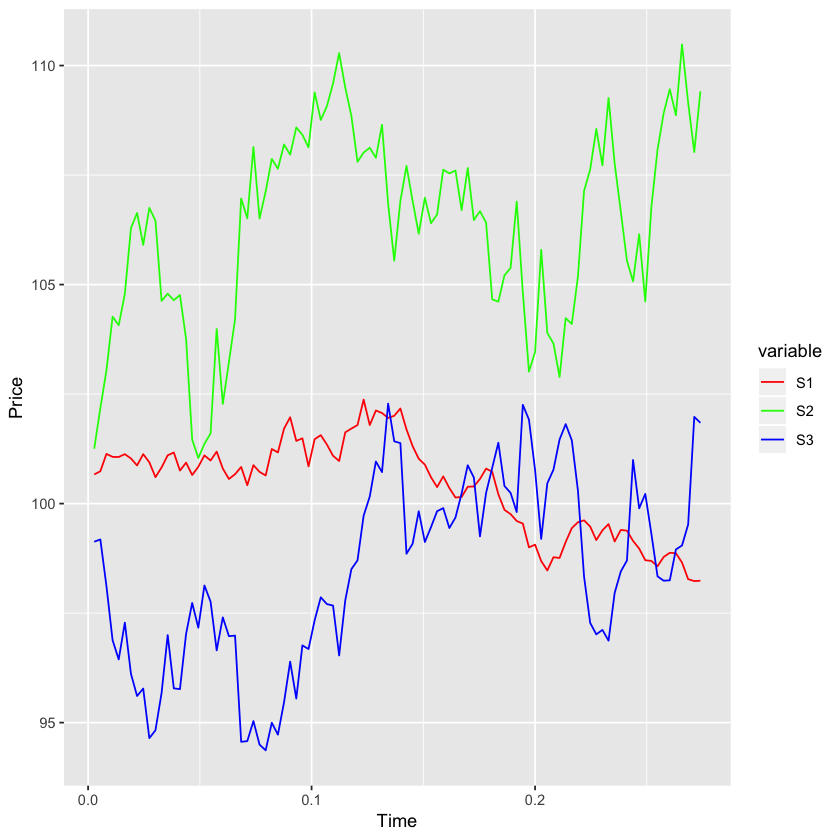

In [9]:
S0=c(100,101,98)
mu=matrix(c(0.03,0.06,0.02),ncol=1)
vol=c(0.05,0.2,0.25)
tau=100/365
n=100
dt=tau/n
#m=1000
matr <-array(NA, c(n,2,3))
dx<- matrix(c(rnorm(3)),ncol = 1)
Bt=0
St=as.matrix(S0)
Stock=matrix(NA,n,4)
colnames(Stock) <- c('t','S1','S2','S3')
for (i in 1:n){
  dx<- matrix(c(rnorm(3)),ncol = 1)
  Bt=LT%*%dx%*%sqrt(dt)
  St=St+mu*St*dt+vol*St*Bt
  matr[i,,]=i*dt
  matr[i,2,1]=St[1]
  matr[i,2,2]=St[2]
  matr[i,2,3]=St[3]
  Stock[i,1]=i*dt
  for (j in 1:3){Stock[i,j+1]=St[j]}
}
Stock <- as.data.frame(Stock)
library (ggplot2)
library (reshape2)
Stock <- melt(Stock,id=c('t'))
z <- ggplot(Stock, aes(Time,Price)) + geom_line(aes(x=t, y=value, colour=variable)) +
  scale_colour_manual(values=c("red","green","blue"))
z

## Pricing Basket Options

Basket options are options on a basket of assets. A commonly traded basket option is a vanilla call/put option on a linear combination of assets. For $S_i(t), i=1,...,N$ which are the price of $N$ stocks at time $t$,
$$
U(t)=\sum_{i=1}^{N}a_iS_i(t)
$$
is the value of these assetes with constant weights $a_i, i=1,...,N$. Specifically, on the exercise date $T$, the payoff of the option is $\max\{\alpha(U(T)-K),0\}$, where $K$ is the exercise price and $\alpha=1$ for a call and $\alpha=-1$ for a put. We will price an European call option and an European put option written on a simple average basket (i.e., $a_i=1/3, i=1,2,3$) with $K = 100$ on the 3 asset basket in the previous part, using a Monte Carlo simulation. 

In [10]:
set.seed(23)
Basket <- function(m,call){
  S0=c(100,101,98)
  K=100
  mu=matrix(c(0.03,0.06,0.02),ncol=1)
  vol=c(0.05,0.2,0.25)
  tau=100/365
  n=100
  dt=tau/n
  dx<- matrix(c(rnorm(3)),ncol = 1)
  Bt=0
  St=as.matrix(S0)
  Sum_CT=0
  for(j in 1:m){
    Bt=0
    St=as.matrix(S0)
    for (i in 1:n){
      dx<- matrix(c(rnorm(3)),ncol = 1)
      Bt=LT%*%dx%*%sqrt(dt)
      St=St+mu*St*dt+vol*St*Bt
    }
    ST=(St[1]+St[2]+St[3])/3
    if (call==TRUE){
      CT=pmax(ST-K,0)}
    else {
      CT=pmax(K-ST,0)}
    Sum_CT=Sum_CT+CT
  }
  disc=exp(-mean(mu)*tau)
  price=Sum_CT/m*disc
  return(price)
}

## Exotic Basket option.
Set $B=104$ and $K=100$, and assume be following:
- If the asset 2 ($S_2$) hits the barrier $B < S_2(t)$ for some $t$, then the payoff of the option is equal to an European Call option written on the asset 2;
- If $\max_{t \in [0,T]} S_2(t) > \max_{t \in [0,T]} S_3(t)$, then the payoff of the option is  $(S_2(T)-K)_{+})$;--
- Take $A_i(0,T) := \sum_{t=1}^{T}S_i(t)$, the average of the daily values for stock $i$. If $A_2(0,T)>A_3(0,T)$,then the payoff is $(A2(0,T)-K)+$;
- otherwise, the option is a vanilla call option on the basket

We will price this option.

In [ ]:
set.seed(23)
S0=c(100,101,98)
K=100
mu=matrix(c(0.03,0.06,0.02),ncol=1)
vol=c(0.05,0.2,0.25)
tau=100/365
n=100
dt=tau/n
m=1000
matr <-array(NA, c(n,m+1,3))
dx <- matrix(c(rnorm(3)),ncol = 1)
Bt=0
St=as.matrix(S0)
#Stock=matrix(NA,n,4)
#colnames(Stock) <- c('t','S1','S2','S3')
B=104
Sum_CT=0
for(j in 1:m){
  Bt=0
  St=as.matrix(S0)
  for (i in 1:n){
    dx<- matrix(c(rnorm(3)),ncol = 1)
    Bt=LT%*%dx%*%sqrt(dt)
    St=St+mu*St*dt+vol*St*Bt
    matr[i,,]=i*dt
    matr[i,j,1]=St[1]
    matr[i,j,2]=St[2]
    matr[i,j,3]=St[3] 
  }
  if (max(matr[,j,2]) > B){ST=St[2]}
  else if (max(matr[,j,2]) > max(matr[,j,3])) {
    ST=St[2]^2-K}
  else if (mean(matr[,j,2])>mean(matr[,j,3])) {
    ST=mean(matr[,j,2])
  }
  else {
    ST=(St[1]+St[2]+St[3])/3
  }
  CT=pmax(ST-K,0)

  Sum_CT=Sum_CT+CT

}
r=mean(r)
disc=exp(-r*tau)
price=Sum_CT/m*disc
print(price)